OVERVIEW OF RESPIRATION PROCESSING PIPELINE

1. load raw data and create dictionary for resp data
2. filter data
    a. linear detrend
    b. band pass filter [0.1, 25] and 3rd order butterworth
    c. smooth signal with savgol filter
3. Manually annotate where "bad signal" occurs using MNE library
4. Turn annotations into a boolean mask 
5. create a csv with 4 columns:
    column 0: timestamps (resp_ts)
    column 1: raw respiration signal (resp_signal)
    column 2: filtered respiration signal (filt_resp)
    column 3: mask for bad signals

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import shutil

# from scipy import signal
from scipy.signal import detrend, butter, filtfilt, savgol_filter

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest

In [4]:
#this sets the backend so that plots will open in a new window (instead of inline), which is required for full functionality of the MNE GUI.
%matplotlib qt

#### Set the recording folder

In [5]:
# update the path to the correct recording folder 
recfolder = r'\\allen\programs\mindscope\workgroups\templeton-psychedelics\mouse709400\aw_ket_2024-02-01_11-12-34\experiment1\recording1'
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
exp_mouse = exp.mouse

print(exp_mouse)
print(exp_tag)

Experiment type: electrical and sensory stimulation
709400
aw_ket


#### Load the raw respiration signal

In [6]:
resp_signal, resp_ts = exp.load_analog_respiration() 

#### Store the respiration signal and timestamps in one dictionary

In [7]:
metadata = {'resp_ts': resp_ts, 'resp_signal': resp_signal}
print(metadata)

{'resp_ts': array([  65.56989668,   65.57029668,   65.57069667, ..., 7688.22415323,
       7688.22455323, 7688.22495323]), 'resp_signal': array([1.64840698, 1.6506958 , 1.65039062, ..., 1.65084839, 1.65481567,
       1.65405273])}


#### Filter the signal
1. detrend https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
2. bandpass + butterworth filter 
3. smooth signal using savgol


#### Linear detrend

In [8]:
detrend_resp = detrend(resp_signal, type='linear')

In [9]:
## Visualize raw vs detrended respiration signal
fig, ax = plt.subplots(figsize=(14,8), constrained_layout=True)
ax.plot(resp_ts, resp_signal, label='Raw Signal', color='grey', alpha=0.8)
ax.plot(resp_ts, detrend_resp, label='Detrended Signal', color='orange', alpha=0.8)
ax.set_ylim([-0.5, 2.0])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend(loc='upper right')
title_str = f"{exp_mouse} {exp_tag} Raw vs Detrended Respiration Signal"
ax.set_title(title_str)

# #save figure
# directory = r'C:\Users\lydia.marks\code\Scripts\respiration analysis\________'  # update this path to your desired directory
# filename = f"{title_str}.png"
# filepath = os.path.join(directory, filename)
# fig.savefig(filepath, transparent=False, dpi=300)

Text(0.5, 1.0, '709400 aw_ket Raw vs Detrended Respiration Signal')

#### Bandpass filter

In [10]:
freqs = [0.1, 25] 
bpb, bpa = butter(3, np.array(freqs)/(2500/2), btype='bandpass') 
bp_resp = filtfilt(bpb, bpa, detrend_resp) 

In [11]:
## Visualize detrended vs. detrend+bp filtered respiration signal
fig, ax = plt.subplots(figsize=(14,8), constrained_layout=True)
ax.plot(resp_ts, detrend_resp, label='Detrended Signal', color='orange', alpha=0.8)
ax.plot(resp_ts, bp_resp, label='Filtered Signal', color='green', alpha=0.8)
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend(loc='upper right')
title_str = f"{exp_mouse} {exp_tag} Detrended vs Filtered Respiration Signal"
ax.set_title(title_str)

# #save figure
# directory = r'C:\Users\lydia.marks\code\Scripts\respiration analysis\________'  # update this path to your desired directory
# filename = f"{title_str}.png"
# filepath = os.path.join(directory, filename)
# fig.savefig(filepath, transparent=False, dpi=300)

Text(0.5, 1.0, '709400 aw_ket Detrended vs Filtered Respiration Signal')

#### Smooth Signal with Savgol Filter

In [12]:
filt_resp = savgol_filter(bp_resp, window_length=35, polyorder=2) #using window_length=35 because this is what Tiffany is doing. could also go with 100 (more conservative and what was in Yiliu's code)

In [13]:
## Visualize Detrend+BP Filter vs. Detrend+BP filt+Smooth respiration signal
fig, ax = plt.subplots(figsize=(14,8), constrained_layout=True)
ax.plot(resp_ts, bp_resp, label='Filtered Signal', color='green', alpha=0.8)
ax.plot(resp_ts, filt_resp, label='Smoothed Filtered Signal', color='blue', alpha=0.8)
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend(loc='upper right')
title_str = f"{exp_mouse} {exp_tag} Filtered vs. Smoothed Respiration Signal"
ax.set_title(title_str)

# #save figure
# directory = r'C:\Users\lydia.marks\code\Scripts\respiration analysis\________'  # update this path to your desired directory
# filename = f"{title_str}.png"
# filepath = os.path.join(directory, filename)
# fig.savefig(filepath, transparent=False, dpi=300)

Text(0.5, 1.0, '709400 aw_ket Filtered vs. Smoothed Respiration Signal')

#### If already annotated data, run cell below to import annotations, check in GUI, and then skip to Transform annotations code block
#### If not annotated data, skip below code block and go to Run MNE GUI

Creating RawArray with float64 data, n_channels=1, n_times=19056640
    Range : 0 ... 19056639 =      0.000 ...  7622.656 secs
Ready.
Using matplotlib as 2D backend.


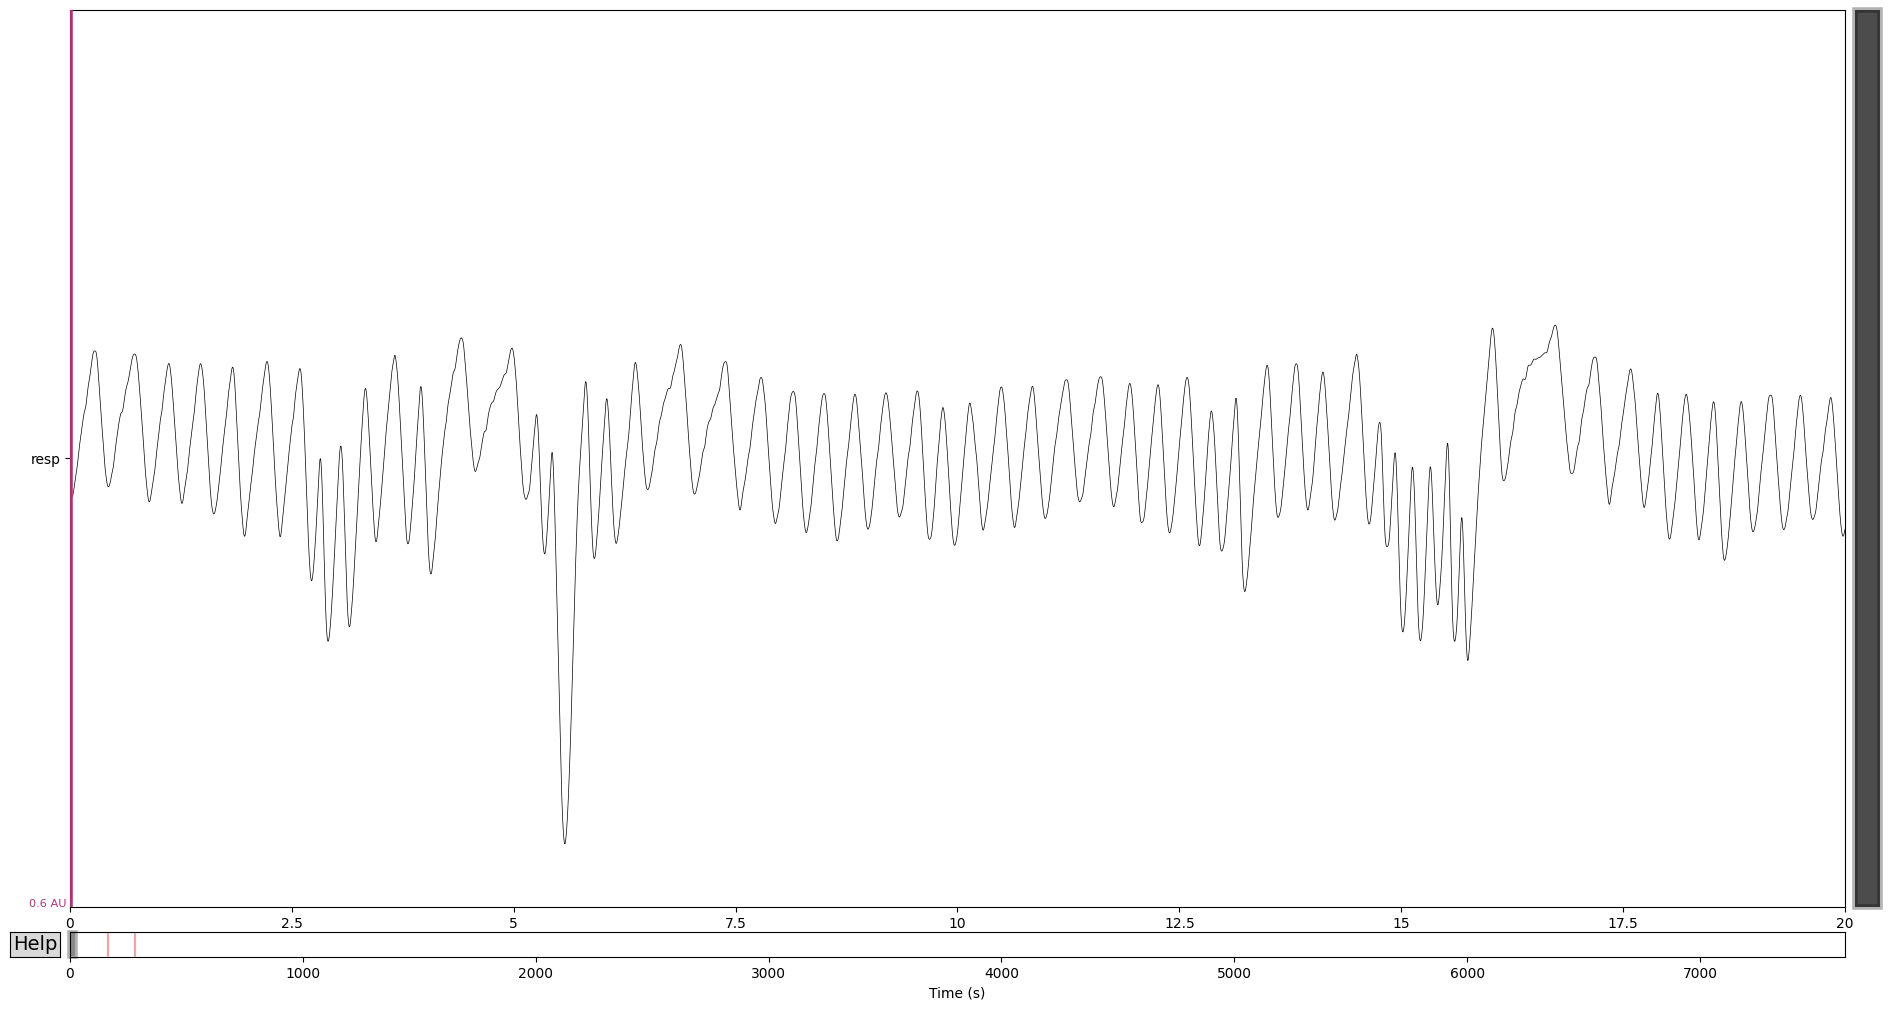

Channels marked as bad:
none


In [14]:
# Load your data into an MNE Raw object 
sfreq = 2500  
data = filt_resp[np.newaxis, :]  # shape: (n_channels, n_times)
info = mne.create_info(ch_names=['resp'], sfreq=sfreq, ch_types=['misc'])
raw = mne.io.RawArray(data, info)

# Load annotations from CSV
df = pd.read_csv(os.path.join(recfolder, f'annotations_{exp_mouse}_{exp_tag}.csv'))
loaded_annots = mne.Annotations(onset=df['onset'], duration=df['duration'], description=df['description'])

# Add annotations to the raw object
raw.set_annotations(loaded_annots)

raw.plot(scalings={'misc': 0.3}, duration=20)   # this opens the viewer to scroll and annotate interactively. 0.3 means +/-0.3 units (Volts)

In [ ]:
print(raw.annotations)

#### Run MNE GUI and annotate signal

Creating RawArray with float64 data, n_channels=1, n_times=19056640
    Range : 0 ... 19056639 =      0.000 ...  7622.656 secs
Ready.


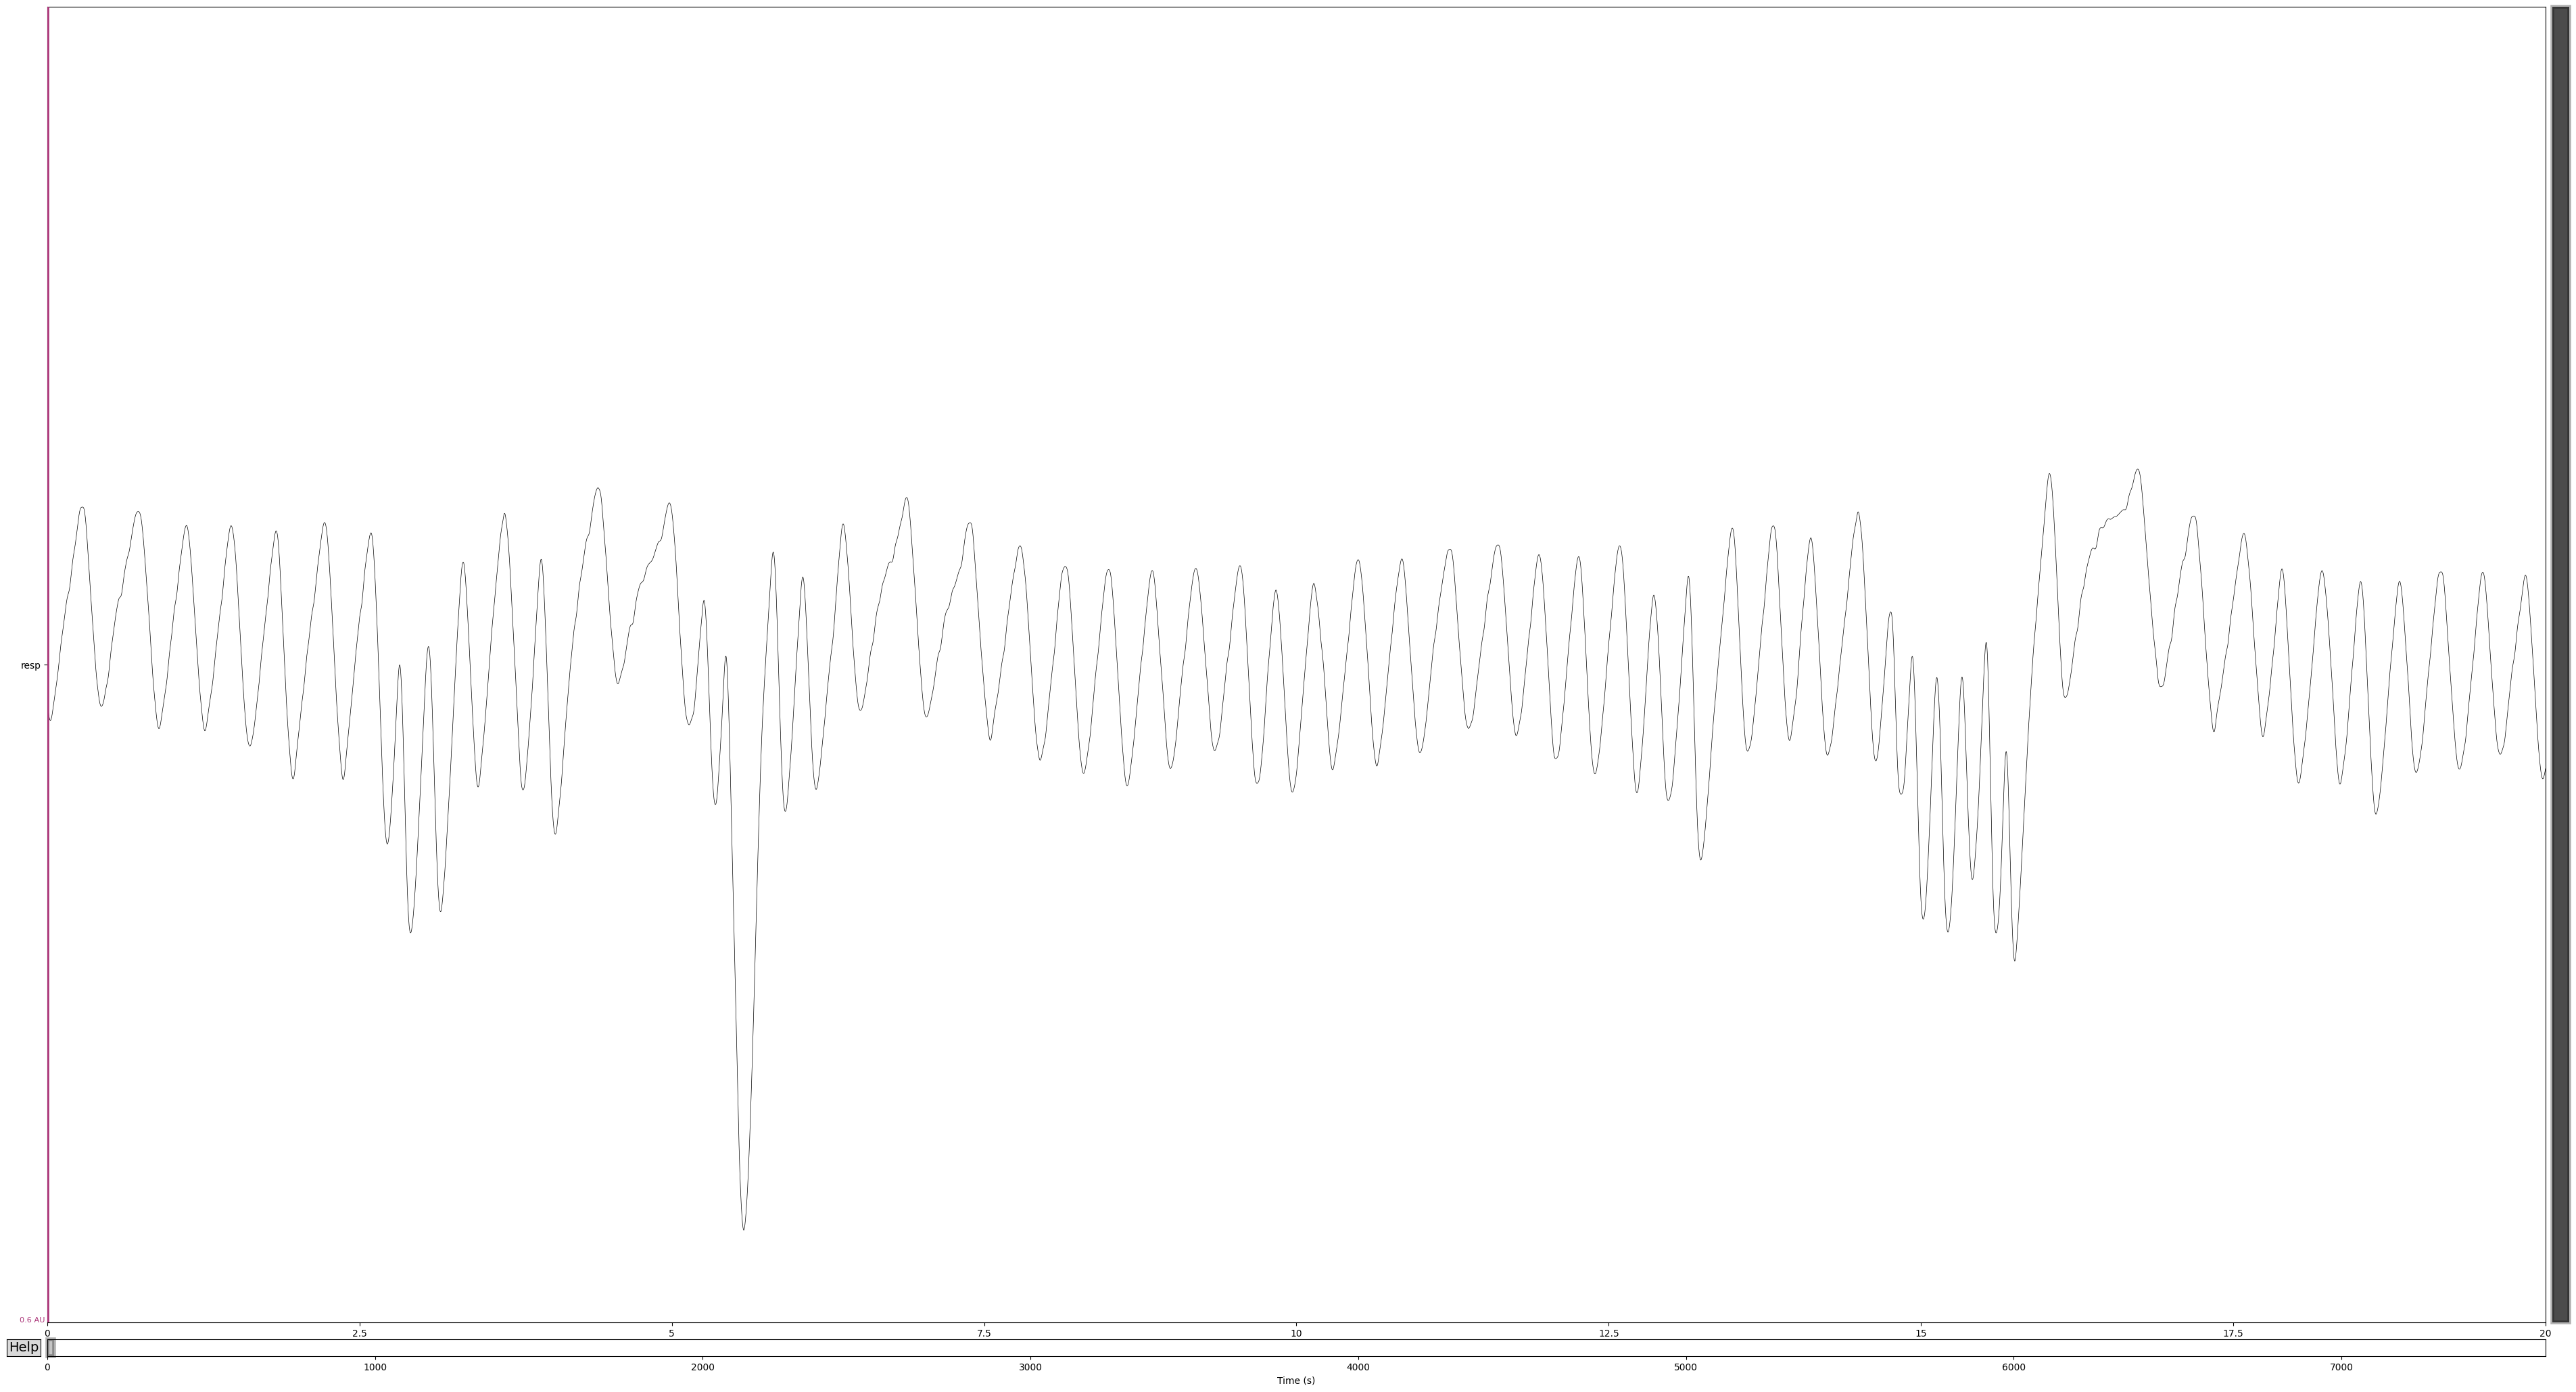

Channels marked as bad:
['resp']


In [41]:
sfreq = 2500  # sampling rate for respiration
data = filt_resp[np.newaxis, :]  # shape: (n_channels, n_times)
info = mne.create_info(ch_names=['resp'], sfreq=sfreq, ch_types=['misc'])
raw = mne.io.RawArray(data, info)

raw.plot(scalings={'misc': 0.3}, duration=20)   # this opens the viewer to scroll and annotate interactively. 0.3 means +/-0.3 units (Volts)

In [42]:
print(raw.annotations)

<Annotations | 2 segments: Bad signal (2)>


#### Save annotations to csv

In [48]:
# Extract annotation info
annotations = raw.annotations
df = pd.DataFrame({
    'onset': annotations.onset,
    'duration': annotations.duration,
    'description': annotations.description
})

# Save to CSV
df.to_csv((f'annotations_{exp_mouse}_{exp_tag}.csv'), index=False)
# Move the CSV file to the recording folder
shutil.move(f'annotations_{exp_mouse}_{exp_tag}.csv', os.path.join(recfolder, f'annotations_{exp_mouse}_{exp_tag}.csv'))

'\\\\allen\\programs\\mindscope\\workgroups\\templeton-psychedelics\\mouse709400\\aw_ket_2024-02-01_11-12-34\\experiment1\\recording1\\annotations_709400_aw_ket.csv'

#### Transform annotations into mask

In [45]:
# Initialize an empty mask (all False)
resp_mask = np.zeros(resp_ts.shape, dtype=bool)

# Loop over annotations
for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
    shifted_onset = onset + resp_ts[0]
    resp_mask |= (resp_ts >= shifted_onset) & (resp_ts < shifted_onset + duration)  # Update the mask for timepoints within the annotation window

#### Make output CSV with 4 columns (timestamps, raw resp signal, filtered resp signal, mask for bad signal)


In [46]:
df = pd.DataFrame({'timestamps': resp_ts, 'raw_respiration_signal(V)': resp_signal, 'filtered respiration signal': filt_resp, 'bad signal mask(True denotes masked bad signal)': resp_mask})

# Save to CSV
df.to_csv((f'respiration_data_{exp_mouse}_{exp_tag}.csv'), index=False)

# Move the CSV file to the recording folder
shutil.move(f'respiration_data_{exp_mouse}_{exp_tag}.csv', os.path.join(recfolder, f'respiration_data_{exp_mouse}_{exp_tag}.csv'))

'\\\\allen\\programs\\mindscope\\workgroups\\templeton-psychedelics\\mouse709400\\aw_ket_2024-02-01_11-12-34\\experiment1\\recording1\\respiration_data_709400_aw_ket.csv'

In [15]:
## Visualize filt_resp signal with masked regions shaded
fig, ax = plt.subplots(figsize=(14,8), constrained_layout=True)
ax.plot(resp_ts, filt_resp, label='Filtered Signal', color='blue', alpha=0.8)

# Overlay the annotations as shaded regions
used_labels = set()
for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
    shifted_onset = onset + resp_ts[0]
    shifted_offset = shifted_onset + duration

    label = desc if desc not in used_labels else None
    plt.axvspan(shifted_onset, shifted_offset, color='red', alpha=0.3, label=label)
    used_labels.add(desc)

ax.set_ylim([-0.5, 0.5])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend(loc='upper right')
title_str = f"{exp_mouse} {exp_tag} Filtered Respiration Signal with Bad signal Highlighted"
ax.set_title(title_str)

# #save figure
# directory = r'C:\Users\lydia.marks\code\Scripts\respiration analysis\________'  # update this path to your desired directory
# filename = f"{title_str}.png"
# filepath = os.path.join(directory, filename)
# fig.savefig(filepath, transparent=False, dpi=300)

Text(0.5, 1.0, '709400 aw_ket Filtered Respiration Signal with Bad signal Highlighted')